In [ ]:
# Import necessary packages
import pandas as pd
from sodapy import Socrata

# Access and load data from API
# API documentation: https://dev.socrata.com/foundry/data.usaid.gov/a3rc-nmf6
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.usaid.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.usaid.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("a3rc-nmf6", limit=20000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

## Part Three: Clean Data For Use In Model

### 2. Inspect Data

In [2]:
results_df.describe()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,10324,10324,10324,10324,10324,10324,10324,10324,10324,9964,...,10324,10324,10324,10324,10324,10324,10324,10324,8588,10037
unique,10324,142,1237,6233,7030,43,4,2,8,4,...,5065,8741,1175,183,88,2,4688,6733,54,6722
top,1,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,10000,200000.0,32.0,0.04,"Aurobindo Unit III, India",True,Weight Captured Separately,Freight Included in Commodity Cost,300mg,0.0
freq,1,768,2681,67,54,1406,10265,5404,5404,6113,...,93,29,368,713,3172,7030,1507,1442,990,54


In [3]:
results_df.head()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,19,551.0,29.0,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,1000,6200.0,6.2,0.03,"Aurobindo Unit III, India",True,358,4521.5,10mg/ml,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,500,40000.0,80.0,0.8,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,150mg,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,38000,121600.0,3.2,0.05,"Aurobindo Unit III, India",True,7590,45450.08,30mg,NaN


In [4]:
results_df.columns

Index(['id', 'project_code', 'pq', 'po_so', 'asn_dn', 'country', 'managed_by',
       'fulfill_via', 'vendor_inco_term', 'shipment_mode',
       'pq_first_sent_to_client_date', 'po_sent_to_vendor_date',
       'scheduled_delivery_date', 'delivered_to_client_date',
       'delivery_recorded_date', 'product_group', 'sub_classification',
       'vendor', 'item_description', 'molecule_test_type', 'brand',
       'dosage_form', 'unit_of_measure_per_pack', 'line_item_quantity',
       'line_item_value', 'pack_price', 'unit_price', 'manufacturing_site',
       'first_line_designation', 'weight_kilograms', 'freight_cost_usd',
       'dosage', 'line_item_insurance_usd'],
      dtype='object')

## Part Two: Extract Data for Use in Model

### 1. Remove columns that are not neccesary

In [5]:
columns_to_drop = ['id', 'po_so', 'pq', 'project_code', 'asn_dn', 'country', 'managed_by', 'vendor_inco_term', 'pack_price', 
                    'shipment_mode', 'first_line_designation', 'unit_of_measure_per_pack',
                   'line_item_insurance_usd', 'fulfill_via', 'pq_first_sent_to_client_date',
                   'po_sent_to_vendor_date', 'scheduled_delivery_date', 'delivered_to_client_date',
                   'delivery_recorded_date', 'pack_price', 'unit_price', 'manufacturing_site', 'first_line_designation',
                   'weight_kilograms', 'freight_cost_usd', 'line_item_insurance_usd', 'dosage', 'item_description', 'vendor',
                   'molecule_test_type']

selected_df = results_df.drop(columns_to_drop, axis=1)


In [6]:
selected_df.columns

Index(['product_group', 'sub_classification', 'brand', 'dosage_form',
       'line_item_quantity', 'line_item_value'],
      dtype='object')

## Part Three: Clean Data For Use In Model

### Step 1: Identify Any Null Values

In [7]:
selected_df.isnull().sum()

product_group         0
sub_classification    0
brand                 0
dosage_form           0
line_item_quantity    0
line_item_value       0
dtype: int64

### Step 2: One-Hot Encode 

In [8]:
selected_df.dtypes

product_group         object
sub_classification    object
brand                 object
dosage_form           object
line_item_quantity    object
line_item_value       object
dtype: object

In [9]:
selected_df['product_group'].unique()

array(['HRDT', 'ARV', 'ACT', 'MRDT', 'ANTM'], dtype=object)

In [10]:
# Encode 
y = pd.get_dummies(selected_df.product_group, prefix='pg')
# Drop old column
selected_df = selected_df.drop('product_group',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,sub_classification,brand,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT
0,HIV test,Reveal,Test kit,19,551.0,0,0,0,1,0
1,Pediatric,Generic,Oral suspension,1000,6200.0,0,0,1,0,0
2,HIV test,Determine,Test kit,500,40000.0,0,0,0,1,0
3,Adult,Generic,Tablet,31920,127360.8,0,0,1,0,0
4,Adult,Generic,Capsule,38000,121600.0,0,0,1,0,0


In [34]:
selected_df['sub_classification'].unique()

array(['HIV test', 'Pediatric', 'Adult', 'HIV test - Ancillary', 'ACT',
       'Malaria'], dtype=object)

In [11]:
# Encode 
y = pd.get_dummies(selected_df.sub_classification, prefix='sc')
# Drop old column
selected_df = selected_df.drop('sub_classification',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,brand,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,sc_HIV test - Ancillary,sc_Malaria,sc_Pediatric
0,Reveal,Test kit,19,551.0,0,0,0,1,0,0,0,1,0,0,0
1,Generic,Oral suspension,1000,6200.0,0,0,1,0,0,0,0,0,0,0,1
2,Determine,Test kit,500,40000.0,0,0,0,1,0,0,0,1,0,0,0
3,Generic,Tablet,31920,127360.8,0,0,1,0,0,0,1,0,0,0,0
4,Generic,Capsule,38000,121600.0,0,0,1,0,0,0,1,0,0,0,0


In [46]:
selected_df['brand'].unique()

array(['Reveal', 'Generic', 'Determine', 'Stocrin/Sustiva', 'Aluvia',
       'Uni-Gold', 'InstantCHEK', 'Videx', 'First Response', 'Stat-Pak',
       'OraQuick', 'Bioline', 'Retrovir', 'Viread', 'Zerit', 'Capillus',
       'Genie', 'Invirase', 'Videx EC', 'Ziagen', 'Coartem', 'Viramune',
       'Paramax', 'Atripla', 'Kaletra', 'Epivir', 'Norvir', 'Truvada',
       'Clearview', 'Colloidal Gold', 'INSTi', 'Trizivir', 'Visitect',
       'Viracept', 'DoubleCheck', 'Bundi', 'ImmunoComb', 'Crixivan',
       'LAV', 'Pepti-LAV', 'Intelence', 'Prezista', 'Isentress',
       'Reyataz', 'Combivir', 'Multispot', 'CareStart', 'Hexagon'],
      dtype=object)

In [12]:
# Encode 
y = pd.get_dummies(selected_df.brand, prefix='brand')
# Drop old column
selected_df = selected_df.drop('brand',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,...,brand_Truvada,brand_Uni-Gold,brand_Videx,brand_Videx EC,brand_Viracept,brand_Viramune,brand_Viread,brand_Visitect,brand_Zerit,brand_Ziagen
0,Test kit,19,551.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Oral suspension,1000,6200.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Test kit,500,40000.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tablet,31920,127360.8,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Capsule,38000,121600.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
selected_df['dosage_form'].unique()

array(['Test kit', 'Oral suspension', 'Tablet', 'Capsule',
       'Oral solution', 'Tablet - FDC', 'Powder for oral solution',
       'Test kit - Ancillary', 'Chewable/dispersible tablet',
       'Delayed-release capsules - blister', 'Tablet - blister',
       'Tablet - FDC + blister', 'Tablet - FDC + co-blister', 'Injection',
       'Delayed-release capsules', 'Chewable/dispersible tablet - FDC',
       'Oral powder'], dtype=object)

In [13]:
# Encode 
y = pd.get_dummies(selected_df.dosage_form, prefix='df')
# Drop old column
selected_df = selected_df.drop('dosage_form',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
0,19,551.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1000,6200.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,500,40000.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,31920,127360.8,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,38000,121600.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Step 3: Change numeric columns to floats/integers

In [16]:
selected_df[['line_item_quantity', 'line_item_value']] = selected_df[['line_item_quantity', 'line_item_value']].apply(pd.to_numeric)
selected_df.dtypes

line_item_quantity                int64
line_item_value                 float64
pg_ACT                            uint8
pg_ANTM                           uint8
pg_ARV                            uint8
                                 ...   
df_Tablet - FDC + blister         uint8
df_Tablet - FDC + co-blister      uint8
df_Tablet - blister               uint8
df_Test kit                       uint8
df_Test kit - Ancillary           uint8
Length: 78, dtype: object

### Step 4: Inspect All Numeric Columns for Outliers & Remove Outliers

<AxesSubplot:ylabel='Frequency'>

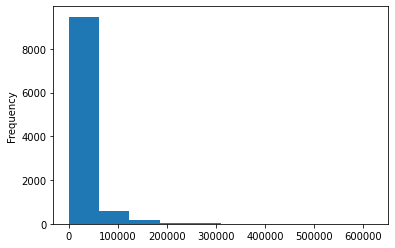

In [17]:
# View histogram
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

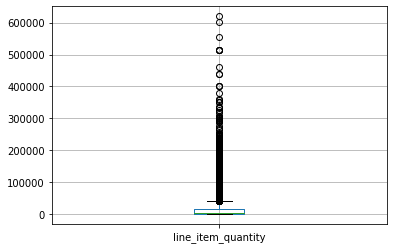

In [19]:
# View boxplot
selected_df.boxplot(column='line_item_quantity')

In [20]:
# Describe data
selected_df['line_item_quantity'].describe()

count     10324.000000
mean      18332.534870
std       40035.302961
min           1.000000
25%         408.000000
50%        3000.000000
75%       17039.750000
max      619999.000000
Name: line_item_quantity, dtype: float64

In [22]:
# Identify upper and lower limits
Q1 = selected_df['line_item_quantity'].quantile(0.25)
Q3 = selected_df['line_item_quantity'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.5 * IQR
Upper = Q3 + 1.5 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -24539.625, upper limit: 41987.375


In [23]:
# Remove outliers
outliers_low = (selected_df['line_item_quantity'] < Lower)
outliers_upper = (selected_df['line_item_quantity'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

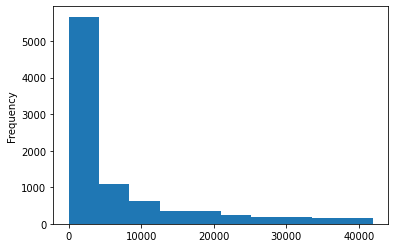

In [24]:
# View histogram with outliers removed
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

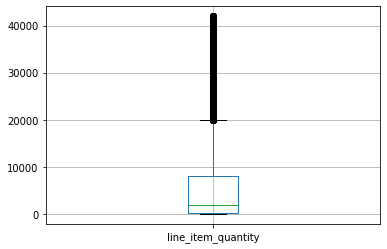

In [25]:
# View boxplot
selected_df.boxplot(column='line_item_quantity')

In [26]:
# Describe data
selected_df['line_item_quantity'].describe()

count     8953.000000
mean      6442.975986
std       9557.972992
min          1.000000
25%        300.000000
50%       2011.000000
75%       8149.000000
max      41949.000000
Name: line_item_quantity, dtype: float64

<AxesSubplot:ylabel='Frequency'>

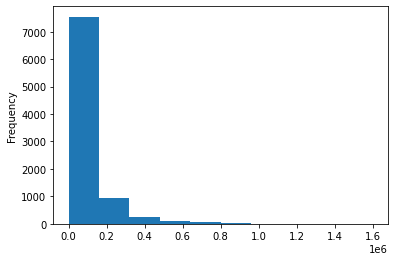

In [27]:
# View histogram
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

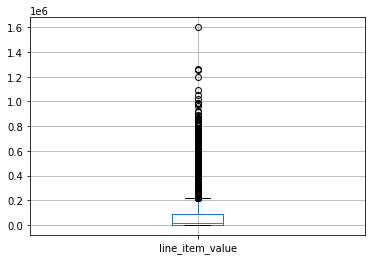

In [28]:
# View boxplot
selected_df.boxplot(column='line_item_value')

In [29]:
# Describe data
selected_df['line_item_value'].describe()

count    8.953000e+03
mean     7.474605e+04
std      1.278411e+05
min      0.000000e+00
25%      3.122550e+03
50%      1.918500e+04
75%      8.887896e+04
max      1.600000e+06
Name: line_item_value, dtype: float64

In [30]:
# Identify upper and lower limits
Q1 = selected_df['line_item_value'].quantile(0.25)
Q3 = selected_df['line_item_value'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.5 * IQR
Upper = Q3 + 1.5 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -125512.065, upper limit: 217513.575


In [31]:
# Remove outliers
outliers_low = (selected_df['line_item_value'] < Lower)
outliers_upper = (selected_df['line_item_value'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

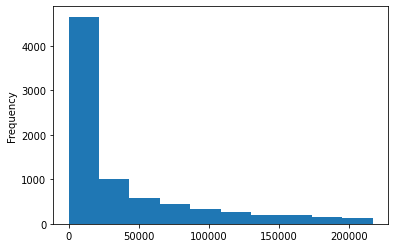

In [32]:
# View histogram
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

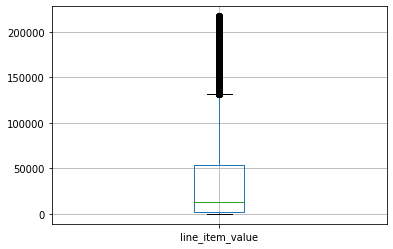

In [33]:
# View boxplot
selected_df.boxplot(column='line_item_value')

In [34]:
# Describe data
selected_df['line_item_value'].describe()

count      7962.000000
mean      37984.232975
std       51464.759421
min           0.000000
25%        2364.750000
50%       13592.500000
75%       53984.375000
max      217047.600000
Name: line_item_value, dtype: float64

### Step 5: Normalize Data

In [35]:
df_max_scaled = selected_df.copy()

In [36]:
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
display(df_max_scaled)

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
0,0.000453,0.002539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.023852,0.028565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011926,0.184291,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.761341,0.586787,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.906359,0.560246,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,0.357773,0.450592,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10317,0.160378,0.096656,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10320,0.502600,0.632992,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10322,0.416567,0.524640,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Part Five: Data Exploration

In [37]:
df_max_scaled.describe()

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
count,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,...,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000
mean,0.118748,0.175004,0.001884,0.002763,0.824667,0.169681,0.001005,0.001884,0.588922,0.149460,...,0.089550,0.025622,0.003517,0.348405,0.201959,0.001884,0.002135,0.001256,0.150465,0.020221
std,0.188527,0.237113,0.043366,0.052496,0.380275,0.375376,0.031684,0.043366,0.492060,0.356564,...,0.285554,0.158014,0.059201,0.476495,0.401487,0.043366,0.046161,0.035420,0.357549,0.140765
min,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005104,0.010895,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.034883,0.062625,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.143109,0.248721,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
pd.options.display.max_rows = 999
df_max_scaled.corr()

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
line_item_quantity,1.000000,0.633705,0.003520,-0.026793,0.210859,-0.208711,-0.018483,0.003520,0.240272,-0.191590,...,-0.111515,0.042887,-0.032622,0.117791,0.217957,-0.021472,0.010841,-0.022006,-0.192700,-0.071261
line_item_value,0.633705,1.000000,0.004228,-0.026105,-0.061005,0.066412,-0.017164,0.004228,0.154181,0.109155,...,-0.151333,-0.072310,-0.041876,-0.004195,0.257417,0.002055,0.020953,-0.024041,0.107333,-0.099394
pg_ACT,0.003520,0.004228,1.000000,-0.002287,-0.094222,-0.019640,-0.001378,1.000000,-0.052001,-0.018212,...,-0.013625,-0.007045,-0.002581,-0.031769,-0.021856,0.799622,0.186236,-0.001541,-0.018284,-0.006241
pg_ANTM,-0.026793,-0.026105,-0.002287,1.000000,-0.114159,-0.023796,-0.001669,-0.002287,-0.063004,-0.022066,...,-0.016508,-0.008536,-0.003127,-0.008361,0.033118,0.163242,-0.002435,0.065689,-0.022153,-0.007562
pg_ARV,0.210859,-0.061005,-0.094222,-0.114159,1.000000,-0.980397,-0.068780,-0.094222,0.551899,-0.909123,...,0.144610,0.074771,0.027392,0.333008,0.223732,-0.094222,-0.000138,0.007025,-0.912713,-0.311563
pg_HRDT,-0.208711,0.066412,-0.019640,-0.023796,-0.980397,1.000000,-0.014337,-0.019640,-0.541080,0.927301,...,-0.141775,-0.073305,-0.026855,-0.330558,-0.227412,-0.019640,-0.020911,-0.016031,0.923476,0.317793
pg_MRDT,-0.018483,-0.017164,-0.001378,-0.001669,-0.068780,-0.014337,1.000000,-0.001378,-0.037959,-0.013294,...,-0.009946,-0.005143,-0.001884,-0.023190,-0.015954,-0.001378,-0.001467,-0.001125,0.075357,-0.004556
sc_ACT,0.003520,0.004228,1.000000,-0.002287,-0.094222,-0.019640,-0.001378,1.000000,-0.052001,-0.018212,...,-0.013625,-0.007045,-0.002581,-0.031769,-0.021856,0.799622,0.186236,-0.001541,-0.018284,-0.006241
sc_Adult,0.240272,0.154181,-0.052001,-0.063004,0.551899,-0.541080,-0.037959,-0.052001,1.000000,-0.501744,...,-0.375381,-0.194092,-0.071105,0.538597,0.353531,-0.052001,0.022056,0.022420,-0.503725,-0.171951
sc_HIV test,-0.191590,0.109155,-0.018212,-0.022066,-0.909123,0.927301,-0.013294,-0.018212,-0.501744,1.000000,...,-0.131468,-0.067976,-0.024903,-0.306527,-0.210880,-0.018212,-0.019391,-0.014865,0.996067,-0.060222


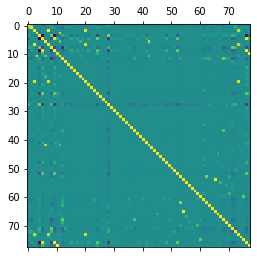

In [40]:
import matplotlib.pyplot as plt

plt.matshow(df_max_scaled.corr())
plt.show()

## Part Six: Create A Model

In [43]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_max_scaled, 
                        test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  6369 Test size:  1593


In [105]:
columns_x = ['line_item_quantity', 'sc_Adult', 'sc_HIV test', 'sc_HIV test - Ancillary', 
            'sc_Pediatric', 'brand_Bioline', 'df_Capsule', 'df_Oral solution', 'df_Tablet - FDC',
            'df_Test kit', 'df_Test kit - Ancillary', 'brand_Determine', 'df_Oral suspension',
            'brand_Aluvia', 'brand_Intelence', 'brand_Kaletra', 'brand_Norvir', 'brand_OraQuick',
            'brand_Retrovir', 'brand_Videx', 'brand_Zerit', 'df_Chewable/dispersible tablet',
            'df_Delayed-release capsules']

In [106]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['line_item_value']

X_test = test_set[columns_x]
y_test = test_set['line_item_value']


lr_model = LinearRegression()
lr_model.fit(X, y)

y_pred = lr_model.predict(X)
print('Results for linear regression on training data')
print('  Default settings')
print('Internal parameters:')
print('   Bias is ', lr_model.intercept_)
print('   Coefficients', lr_model.coef_)
print('   Score', lr_model.score(X, y))

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = lr_model.predict(X_test)
print()
print('Results for linear regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for linear regression on training data
  Default settings
Internal parameters:
   Bias is  -0.001366731632090834
   Coefficients [ 0.81903862  0.04159014  0.14061137 -0.02815605 -0.00482782  0.12462432
 -0.00576007  0.00598329  0.09284326  0.02212645 -0.02815605  0.11499256
 -0.06212503  0.22995451 -0.02254798  0.0869428  -0.01034241 -0.08295533
  0.00285683  0.00802853 -0.02523697  0.03089898 -0.01141855]
   Score 0.5338344012512466
MAE is    0.10856770616301514
RMSE is   0.16105006615700102
MSE is    0.025937123809174404
R^2       0.5338344012512466

Results for linear regression on test data
MAE is    0.11057717981985174
RMSE is   0.16882338788014803
MSE is    0.028501336295330915
R^2       0.5129230926243187


In [107]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['line_item_value']

X_test = test_set[columns_x]
y_test = test_set['line_item_value']

dt_model = DecisionTreeRegressor(random_state = 0, max_depth=5) 
dt_model.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [108]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.07274674088951687
RMSE is   0.1209880944432351
MSE is    0.014638118997005177
R^2       0.7369104008216698

Results for decision tree regression on test data
MAE is    0.0755683572898573
RMSE is   0.1303090544204758
MSE is    0.01698044966395852
R^2       0.7098106270363098


In [109]:
# import the regressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

X = train_set[columns_x]
y = train_set['line_item_value']

X_test = test_set[columns_x]
y_test = test_set['line_item_value']

dt_model = ExtraTreesRegressor(random_state = 0, n_estimators=30)
dt_model.fit(X, y)

ExtraTreesRegressor(n_estimators=30, random_state=0)

In [110]:
y_pred = dt_model.predict(X)
print('Results for decision tree regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

y_test_pred = dt_model.predict(X_test)
print()
print('Results for decision tree regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.013054801536576437
RMSE is   0.04776095999145659
MSE is    0.002281109299305517
R^2       0.9590018272594292

Results for decision tree regression on test data
MAE is    0.06581739083211315
RMSE is   0.13177126504216655
MSE is    0.0173636662908129
R^2       0.7032616018422262
